**Importing libraries**

In [1]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

**Defining plotting parameters**

In [2]:
dpi = 90

**Defining constants**

In [3]:
omega_m = 0.272            #matter density paratmeter from Komatsu et al. (2011) 
omega_l = 1 - omega_m      #vacuum density paratmeter assuming flat universe
H_o = 70.4                 #Hubble constant in km s^−1 Mpc^−1 from Komatsu et al. (2011) 
h = 0.704
f = omega_m**0.545         #linear velocity growth rate from Tanimura et al. (2020)


**Defining Functions**

In [4]:
def H(z):                           #hubble parameter (in km s^-1 Mpc^-1) using Eq. 4.33 in Peter's book
    return np.sqrt( H_o**2 * ( (1+z)**3 * omega_m + omega_l ) ) 


**Reading galaxies dataset**

In [99]:
%%time
z = 0.42
# data_address = '../input/magneticumsnap027z042-massfiltered/'
data_address = 'Data/'
df_gal = pd.read_csv(data_address + 'massive_galaxies.csv')      #massive_galaxies.csv contains galaxies with mass greater than 1.8 ×10^{11} h^{−1} M_sun as done by Tanimura et al. (2020)
print(df_gal.describe())


            x[kpc/h]       y[kpc/h]       z[kpc/h]     m[Msol/h]  \
count   93097.000000   93097.000000   93097.000000  9.309700e+04   
mean   325576.133087  322500.028738  320613.762863  3.993206e+11   
std    184863.273960  182799.587421  183249.915097  3.995129e+11   
min         1.864417      10.164207       0.260974  1.800010e+11   
25%    163866.950000  166201.380000  162514.560000  2.161480e+11   
50%    332449.620000  329260.160000  319925.780000  2.784900e+11   
75%    483949.000000  475466.120000  478698.410000  4.192930e+11   
max    639996.190000  639980.940000  639993.120000  1.077460e+13   

       m_gas[Msol/h]  
count   9.309700e+04  
mean    1.326202e+12  
std     2.955465e+12  
min     0.000000e+00  
25%     2.976010e+11  
50%     5.810010e+11  
75%     1.244070e+12  
max     1.420090e+14  
CPU times: user 95.8 ms, sys: 11.7 ms, total: 108 ms
Wall time: 106 ms


**Reading clusters dataset**

In [6]:
%%time

df_clusters = pd.read_csv(data_address + 'massive_clusters.csv', 
                          usecols = ['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'm500c[Msol/h]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'    ])  #massive_clusters.csv contains clusters with M_500c greater than 10^13.5 h^{-1} M_sun as done by Tanimura et al. (2020)

#removing cluster at edges of the survey volume as done by Tanimura et al. 2020
df_clusters = df_clusters[(df_clusters['x[kpc/h]'] > 120000) & (df_clusters['x[kpc/h]'] < 530000) 
                          & (df_clusters['y[kpc/h]'] > 120000) & (df_clusters['y[kpc/h]'] < 530000) 
                          & (df_clusters['z[kpc/h]'] > 120000) & (df_clusters['z[kpc/h]'] < 530000)]
        
print(df_clusters.describe())

            x[kpc/h]       y[kpc/h]       z[kpc/h]  m500c[Msol/h]  \
count    1592.000000    1592.000000    1592.000000   1.592000e+03   
mean   326225.714152  330893.131420  319484.322167   6.318661e+13   
std    117744.272442  117949.607936  117197.038213   4.845334e+13   
min    120050.600000  120120.120000  120140.480000   3.163600e+13   
25%    225829.552500  234986.600000  221053.682500   3.819940e+13   
50%    328897.030000  336651.920000  313286.765000   4.811530e+13   
75%    427401.647500  433925.950000  426564.770000   7.023110e+13   
max    529929.500000  529911.120000  529783.620000   7.220310e+14   

          vx[km/s]     vy[km/s]     vz[km/s]  
count  1592.000000  1592.000000  1592.000000  
mean     56.881581    47.430418    -7.541318  
std     285.013942   296.601694   277.891742  
min   -1179.530000 -1107.410000 -1064.920000  
25%    -120.642250  -147.272250  -186.943250  
50%      58.529550    60.448700   -13.359600  
75%     238.076250   252.000000   177.276500  
ma

**Specifying prefactors for Eq. 1 of Tanimura et al. (2020)**

In [7]:
a = 1/(1+z)
H(z)
print(H(z))

pre_fac = (f * a * H(z) / (4 * np.pi))           #in km s^−1 Mpc^−1 
pre_fac

86.41766566802045


2.3820143592892085

**Calculating mean density of the simulation box**

In [86]:
df_gal_mean = df_gal.copy()

df_gal_mean['x[kpc/h]'] = df_gal_mean['x[kpc/h]'] / 5000
df_gal_mean['y[kpc/h]'] = df_gal_mean['y[kpc/h]'] / 5000
df_gal_mean['z[kpc/h]'] = df_gal_mean['z[kpc/h]'] / 5000

#making tuples, converting tuples to cell coordinates
df_gal_mean["cell"] = list(zip(df_gal_mean['x[kpc/h]'].astype(int), df_gal_mean['y[kpc/h]'].astype(int), df_gal_mean['z[kpc/h]'].astype(int)))

#array to store number of galaxies in the cells
gals_in_cell = np.zeros((130, 130, 130))

#counting number of galaxies in the cells
for cell in df_gal_mean["cell"]:
    x, y, z = cell
    gals_in_cell[x, y, z] += 1

delta_gal_mean = np.mean(gals_in_cell)
print(delta_gal_mean)
# print(df_gal_mean.describe())

0.04237460172963132


**Evaluating Eq. 1 of Tanimura el al. 2020**

In [87]:
%%time

pix_size = 5000                      #h^-1 kpc, size of pixel or cell
FWHM = 2000                          #h^-1 kpc, of Gaussian kernel, taken by Tanimura et al. 2020
FWHM_in_pix = 2000/pix_size          #in pixel units
sigma_in_pix = FWHM_in_pix/(2.35482) #in pixel units
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

#specifing position of the clusters
Rclus_x = np.zeros((48, 48, 48))
Rclus_x[:] = 120000
Rclus_y = np.zeros((48, 48, 48))
Rclus_y[:] = 120000
Rclus_z = np.zeros((48, 48, 48))
Rclus_z[:] = 120000

#generating meshgrid containing coordinates of the centers of cells
# x = np.arange(2500, 238000, 5000)
# Rcell_x, Rcell_y, Rcell_z = np.meshgrid(x, x, x)

Rcell_x = np.zeros((48, 48, 48))
Rcell_y = np.zeros((48, 48, 48))
Rcell_z = np.zeros((48, 48, 48))

for i, val in enumerate(range(2500, 238000, 5000)):
    Rcell_x[i,:,:] = val
    Rcell_y[:,i,:] = val
    Rcell_z[:,:,i] = val


#evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

#calculating the differential in the Eq. 1
dy_cubed = pix_size**3

#evaluating the direction term in the numerator of Eq. 1
numer_x = Rcell_x - Rclus_x
numer_y = Rcell_y - Rclus_y
numer_z = Rcell_z - Rclus_z

#generating empty lists to store velocity estimates later on
# vx_est_list = []
# vy_est_list = []
# vz_est_list = []

def density_field_calc(clus_x, clus_y, clus_z):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_gal[(df_gal['x[kpc/h]'] >= (clus_x - 120000)) & (df_gal['x[kpc/h]'] < (clus_x + 120000))
                            & (df_gal['y[kpc/h]'] >= (clus_y - 120000)) & (df_gal['y[kpc/h]'] < (clus_y + 120000)) 
                             & (df_gal['z[kpc/h]'] >= (clus_z - 120000)) & (df_gal['z[kpc/h]'] < (clus_z + 120000))]
    
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['x[kpc/h]'] -= (clus_x-120000)
    df_gal_cube['y[kpc/h]'] -= (clus_y-120000)
    df_gal_cube['z[kpc/h]'] -= (clus_z-120000)

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['x[kpc/h]'] = df_gal_cube['x[kpc/h]'] / 5000
    df_gal_cube['y[kpc/h]'] = df_gal_cube['y[kpc/h]'] / 5000
    df_gal_cube['z[kpc/h]'] = df_gal_cube['z[kpc/h]'] / 5000
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'].astype(int), df_gal_cube['y[kpc/h]'].astype(int), df_gal_cube['z[kpc/h]'].astype(int)))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((48, 48, 48))
    
    #counting number of galaxies in the cells
    for cell in df_gal_cube["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1
        
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/delta_gal_mean) - 1
        
    #smoothing the overdensity of galaxies
    delta_gal_smooth = gaussian_filter(delta_gal, sigma = sigma_in_pix)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(h*1e3)) / denom #in units of Mpc    
    vx_est = pre_fac * np.sum(integrand_x)
#     vx_est_list.append(vx_est)
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(h*1e3)) / denom #in units of Mpc    
    vy_est = pre_fac * np.sum(integrand_y)
#     vy_est_list.append(vy_est)
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(h*1e3)) / denom #in units of Mpc    
    vz_est = pre_fac * np.sum(integrand_z)
#     vz_est_list.append(vz_est)
    
    return(vx_est, vy_est, vz_est)


clus_param = [(clus_x, clus_y, clus_z) for clus_x, clus_y, clus_z
              in zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'])]


# counter = 0

# for clus_x, clus_y, clus_z in zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]']):
#     density_field_calc(clus_x, clus_y, clus_z)
    
#     counter += 1
#     if counter == 5:
#         break


# clus_param = [(clus_x, clus_y, clus_z) for clus_x, clus_y, clus_z  
#               in zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'])]

clus_param = list(zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]']))
# density_field_calc('416658.59', '455771.69', '72710.742', '-164.10600')

pool = multi.Pool(processes = 8)
v_est = pool.starmap(density_field_calc, clus_param)

vx_est_list = [i[0] for i in v_est]
vy_est_list = [i[1] for i in v_est]
vz_est_list = [i[2] for i in v_est]

CPU times: user 147 ms, sys: 112 ms, total: 259 ms
Wall time: 9.27 s


In [100]:
df_gal_mean = df_gal.copy()

# print(df_gal_mean.describe())

df_gal_mean['x[kpc/h]'] = df_gal_mean['x[kpc/h]'] / 5000
df_gal_mean['y[kpc/h]'] = df_gal_mean['y[kpc/h]'] / 5000
df_gal_mean['z[kpc/h]'] = df_gal_mean['z[kpc/h]'] / 5000

#making tuples, converting tuples to cell coordinates
df_gal_mean["cell"] = list(zip(df_gal_mean['x[kpc/h]'].astype(int), df_gal_mean['y[kpc/h]'].astype(int), df_gal_mean['z[kpc/h]'].astype(int)))

# print(df_gal_mean.describe())

#array to store number of galaxies in the cells
gals_mass_in_cell = np.zeros((130, 130, 130))

#counting number of galaxies in the cells
for cell, mass, mass_gas in zip(df_gal_mean["cell"], df_gal_mean['m[Msol/h]'], df_gal_mean['m_gas[Msol/h]']):
    x, y, z = cell
    gals_mass_in_cell[x, y, z] += (mass + mass_gas)

delta_gal_mean = np.mean(gals_mass_in_cell)
print(delta_gal_mean)
# print(df_gal_mean.describe())

73118316293.71837


In [101]:
%%time

pix_size = 5000                      #h^-1 kpc, size of pixel or cell
FWHM = 2000                          #h^-1 kpc, of Gaussian kernel, taken by Tanimura et al. 2020
FWHM_in_pix = 2000/pix_size          #in pixel units
sigma_in_pix = FWHM_in_pix/(2.35482) #in pixel units
b = 1                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

#specifing position of the clusters
Rclus_x = np.zeros((48, 48, 48))
Rclus_x[:] = 120000
Rclus_y = np.zeros((48, 48, 48))
Rclus_y[:] = 120000
Rclus_z = np.zeros((48, 48, 48))
Rclus_z[:] = 120000

#generating meshgrid containing coordinates of the centers of cells
# x = np.arange(2500, 238000, 5000)
# Rcell_x, Rcell_y, Rcell_z = np.meshgrid(x, x, x)

Rcell_x = np.zeros((48, 48, 48))
Rcell_y = np.zeros((48, 48, 48))
Rcell_z = np.zeros((48, 48, 48))

for i, val in enumerate(range(2500, 238000, 5000)):
    Rcell_x[i,:,:] = val
    Rcell_y[:,i,:] = val
    Rcell_z[:,:,i] = val


#evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

#calculating the differential in the Eq. 1
dy_cubed = pix_size**3

#evaluating the direction term in the numerator of Eq. 1
numer_x = Rcell_x - Rclus_x
numer_y = Rcell_y - Rclus_y
numer_z = Rcell_z - Rclus_z

#generating empty lists to store velocity estimates later on
vx_est_list = []
vy_est_list = []
vz_est_list = []

def density_field_calc(clus_x, clus_y, clus_z):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_gal[(df_gal['x[kpc/h]'] >= (clus_x - 120000)) & (df_gal['x[kpc/h]'] < (clus_x + 120000))
                            & (df_gal['y[kpc/h]'] >= (clus_y - 120000)) & (df_gal['y[kpc/h]'] < (clus_y + 120000)) 
                             & (df_gal['z[kpc/h]'] >= (clus_z - 120000)) & (df_gal['z[kpc/h]'] < (clus_z + 120000))]
    
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['x[kpc/h]'] -= (clus_x-120000)
    df_gal_cube['y[kpc/h]'] -= (clus_y-120000)
    df_gal_cube['z[kpc/h]'] -= (clus_z-120000)

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['x[kpc/h]'] = df_gal_cube['x[kpc/h]'] / 5000
    df_gal_cube['y[kpc/h]'] = df_gal_cube['y[kpc/h]'] / 5000
    df_gal_cube['z[kpc/h]'] = df_gal_cube['z[kpc/h]'] / 5000
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'].astype(int), df_gal_cube['y[kpc/h]'].astype(int), df_gal_cube['z[kpc/h]'].astype(int)))
    
    #array to store number of galaxies in the cells
    gals_mass_in_cell = np.zeros((48, 48, 48))
    
    #counting number of galaxies in the cells
    for cell, mass, mass_gas in zip(df_gal_cube["cell"], df_gal_cube['m[Msol/h]'], df_gal_cube['m_gas[Msol/h]']):
        x, y, z = cell
        gals_mass_in_cell[x, y, z] += (mass + mass_gas)
        
    #determining the overdensity of galaxies    
    delta_gal = (gals_mass_in_cell/delta_gal_mean) - 1
        
    #smoothing the overdensity of galaxies
    delta_gal_smooth = gaussian_filter(delta_gal, sigma = sigma_in_pix)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(h*1e3)) / denom #in units of Mpc    
    vx_est = pre_fac * np.sum(integrand_x)
#     vx_est_list.append(vx_est)
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(h*1e3)) / denom #in units of Mpc    
    vy_est = pre_fac * np.sum(integrand_y)
#     vy_est_list.append(vy_est)
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(h*1e3)) / denom #in units of Mpc    
    vz_est = pre_fac * np.sum(integrand_z)
#     vz_est_list.append(vz_est)
    
    return(vx_est, vy_est, vz_est)


# clus_param = [(clus_x, clus_y, clus_z) for clus_x, clus_y, clus_z
#               in zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'])]


# # counter = 0

# for clus_x, clus_y, clus_z in zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]']):
#     density_field_calc(clus_x, clus_y, clus_z)
    
#     counter += 1
#     if counter == 5:
#         break

clus_param = list(zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]']))
# density_field_calc('416658.59', '455771.69', '72710.742', '-164.10600')

pool = multi.Pool(processes = 8)
v_est = pool.starmap(density_field_calc, clus_param)

vx_est_list = [i[0] for i in v_est]
vy_est_list = [i[1] for i in v_est]
vz_est_list = [i[2] for i in v_est]

CPU times: user 132 ms, sys: 118 ms, total: 250 ms
Wall time: 10 s


**Line of sight velocity**

54.735610317245346


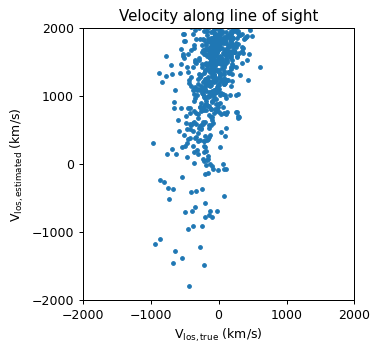

In [102]:
#line of sight assumed to along main diagonal(from '0,0,0' -> '650,650,650') of the simulation cube

theta = np.arccos(1/np.sqrt(1+1+1))
print(theta*(180/np.pi))

vx_est_array = np.array(vx_est_list)
vy_est_array = np.array(vy_est_list)
vz_est_array = np.array(vz_est_list)

v_los_est = (vx_est_array * np.cos(theta)) + (vy_est_array * np.cos(theta)) + (vz_est_array * np.cos(theta))
v_los_true = (df_clusters['vx[km/s]'] * np.cos(theta)) + (df_clusters['vy[km/s]'] * np.cos(theta)) + (df_clusters['vz[km/s]'] * np.cos(theta))

plt.figure(dpi = dpi)
plt.scatter(v_los_true, v_los_est, s = 8)
plt.xlabel('V$_\mathrm{los, true}$ (km/s)')
plt.ylabel('V$_\mathrm{los, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Velocity along line of sight');

2953.6747653111634 -3097.022765356165


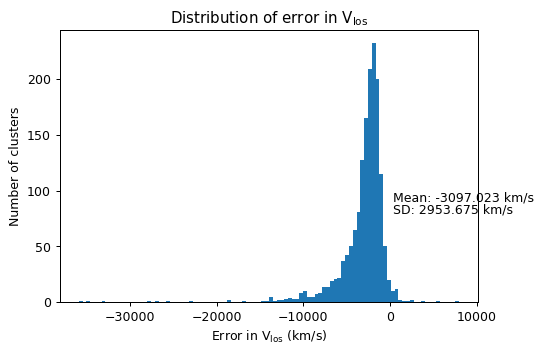

In [103]:
error_v_los = v_los_true - v_los_est

plt.figure(dpi = dpi)
plt.hist(error_v_los, bins = 100)
plt.xlabel('Error in V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('Number of clusters')
plt.title('Distribution of error in V$_\mathrm{los}$')

print(np.std(error_v_los), np.mean(error_v_los))
plt.text(400, 90, f'Mean: {round(np.mean(error_v_los), 3)} km/s')
plt.text(400, 80, f'SD: {round(np.std(error_v_los), 3)} km/s');

In [104]:
print(v_est[2][0])
# print(v_est[0-2][0])
# print(v_est[0:5])
# vx_est = [i[0] for i in v_est]
# print(vx_est[0:5])

18790.647485555957


**V$_x$ estimate & error**

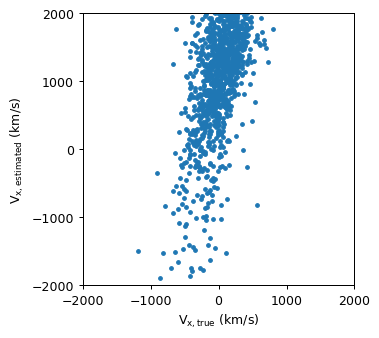

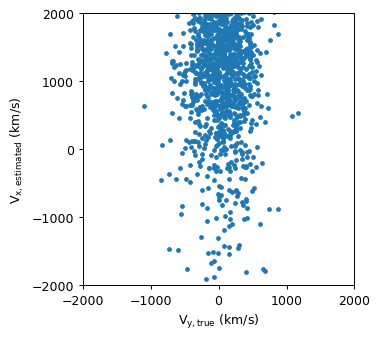

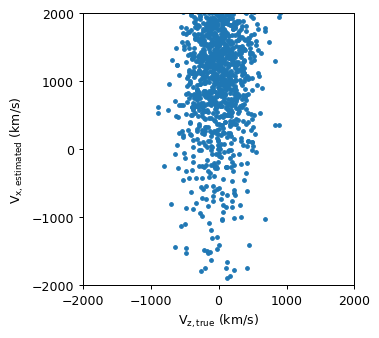

In [105]:
plt.figure(dpi = dpi)
# plt.scatter(df_clusters['vx[km/s]'], vx_est_list, s = 8)
plt.scatter(df_clusters['vx[km/s]'], vx_est_list, s = 8)
plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vy[km/s]'], vx_est_list, s = 8)
plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vz[km/s]'], vx_est_list, s = 8)
plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)');
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')

1962.8915196798464 -1781.5960286320426


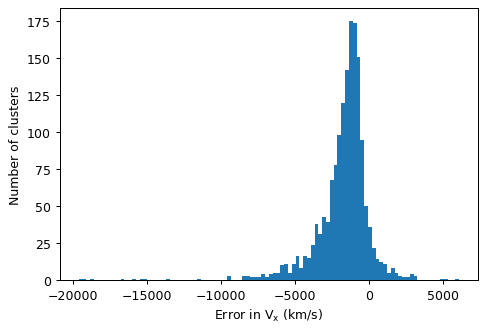

In [106]:
error_x = df_clusters['vx[km/s]'] - vx_est_list

plt.figure(dpi = dpi)
plt.hist(error_x, bins = 100)
plt.xlabel('Error in V$_{\mathrm{x}}$ (km/s)')
plt.ylabel('Number of clusters')

print(np.std(error_x), np.mean(error_x))

**V$_y$ estimate & error**

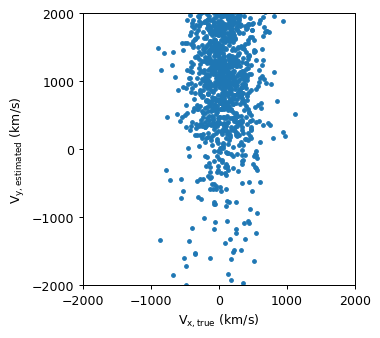

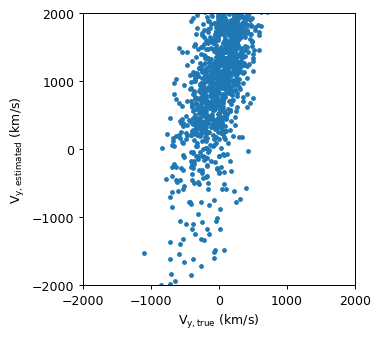

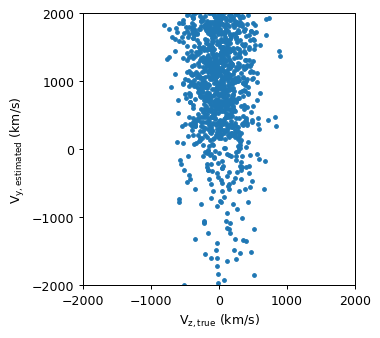

In [107]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters['vx[km/s]'], vy_est_list, s = 8)
plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)')
plt.gca().set_xticks(np.arange(-2000, 2001, 1000))
plt.gca().set_yticks(np.arange(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vy[km/s]'], vy_est_list, s = 8)
plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vz[km/s]'], vy_est_list, s = 8)
plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)');
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.ylim(-2000,2000)
plt.gca().set_aspect('equal', adjustable='box')

1973.2007627487571 -1809.4824144613956


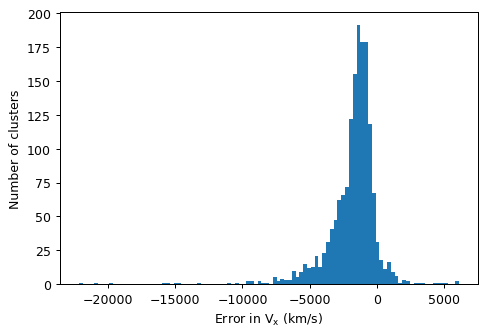

In [108]:
error_y = df_clusters['vy[km/s]'] - vy_est_list

plt.figure(dpi = dpi)
plt.hist(error_y, bins = 100)
plt.xlabel('Error in V$_{\mathrm{x}}$ (km/s)')
plt.ylabel('Number of clusters')

print(np.std(error_y), np.mean(error_y))

**V$_z$ estimate & error**

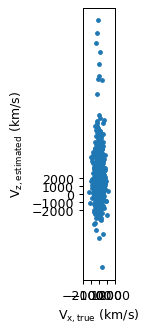

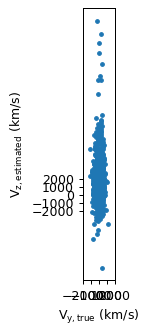

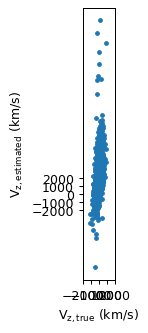

In [109]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters['vx[km/s]'], vz_est_list, s = 8)
plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vy[km/s]'], vz_est_list, s = 8)
plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vz[km/s]'], vz_est_list, s = 8)
plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)');
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

2002.342653391292 -1773.1223387009131


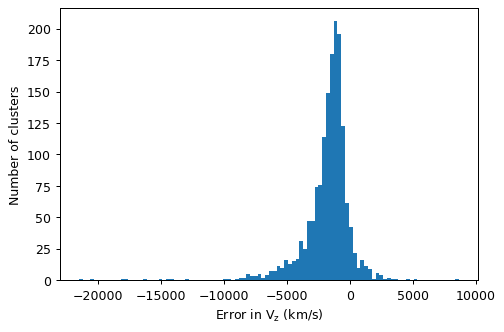

In [110]:
error_z = df_clusters['vz[km/s]'] - vz_est_list

plt.figure(dpi = dpi)
plt.hist(error_z, bins = 100)
plt.xlabel('Error in V$_{\mathrm{z}}$ (km/s)')
plt.ylabel('Number of clusters')

print(np.std(error_z), np.mean(error_z))